<a href="https://colab.research.google.com/github/sayakpaul/Training-BatchNorm-and-Only-BatchNorm/blob/master/Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
- https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
# !pip install wandb -q
import wandb
# wandb.login()

In [0]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import tensorflow as tf
import resnet_cifar10
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [0]:
LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog",
	"frog", "horse", "ship", "truck"]

In [0]:
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_test = x_test/255.

In [0]:
def get_training_model(optimizer="sgd"):
    # ResNet20
    n = 2
    depth =  n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = Input(shape=(32, 32, 3))

    # The Stem Convolution Group
    x = resnet_cifar10.stem(inputs)

    # The learner
    x = resnet_cifar10.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet_cifar10.classifier(x, 10)

    # Instantiate the Model
    model = Model(inputs, outputs)

    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [0]:
def get_sample_test_image():
    idx = np.random.choice(x_test.shape[0], 1)
    plt.imshow(x_test[idx].squeeze(0))
    plt.title(LABELS[int(y_test[idx])])
    plt.show()
    return idx

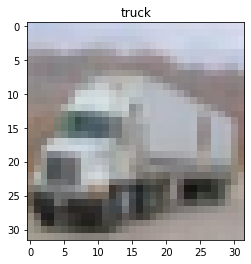

In [17]:
# Test
sample_image_id = get_sample_test_image()
sample_image = x_test[sample_image_id]

In [0]:
# Load the weights
resnet_adam = get_training_model("adam")
resnet_adam_weights = wandb.restore("model-best.h5", run_path="sayakpaul/training-bn-only/resnet-ramups-adam")
resnet_adam.load_weights(resnet_adam_weights.name)

In [19]:
# Predictions
predictions = resnet_adam.predict(sample_image)
idx = np.argmax(predictions[0])
print(LABELS[idx])

truck


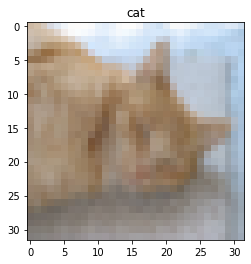

In [20]:
# Take another sample 
sample_image_id = get_sample_test_image()
sample_image = x_test[sample_image_id]

In [21]:
# Inspect the output shapes of the conv layers
conv_ids = []
for i in range(len(resnet_adam.layers)):
	layer = resnet_adam.layers[i]
	# check for convolutional layer
	if "conv" not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)
	conv_ids.append(i)

1 conv2d_188 (None, 32, 32, 16)
4 conv2d_190 (None, 32, 32, 16)
7 conv2d_191 (None, 32, 32, 16)
10 conv2d_192 (None, 32, 32, 64)
11 conv2d_189 (None, 32, 32, 64)
15 conv2d_193 (None, 32, 32, 16)
18 conv2d_194 (None, 32, 32, 16)
21 conv2d_195 (None, 32, 32, 64)
25 conv2d_197 (None, 32, 32, 64)
28 conv2d_198 (None, 16, 16, 64)
31 conv2d_199 (None, 16, 16, 128)
32 conv2d_196 (None, 16, 16, 128)
36 conv2d_200 (None, 16, 16, 64)
39 conv2d_201 (None, 16, 16, 64)
42 conv2d_202 (None, 16, 16, 128)
46 conv2d_204 (None, 16, 16, 128)
49 conv2d_205 (None, 8, 8, 128)
52 conv2d_206 (None, 8, 8, 256)
53 conv2d_203 (None, 8, 8, 256)
57 conv2d_207 (None, 8, 8, 128)
60 conv2d_208 (None, 8, 8, 128)
63 conv2d_209 (None, 8, 8, 256)


In [33]:
# conv layer at 10th index
model = Model(inputs=resnet_adam.inputs, outputs=resnet_adam.layers[10].output)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_184 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
re_lu_184 (ReLU)             (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 32, 32, 16)        272       
_________________________________________________________________
batch_normalization_185 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
re_lu_185 (ReLU)             (None, 32, 32, 16)        0   

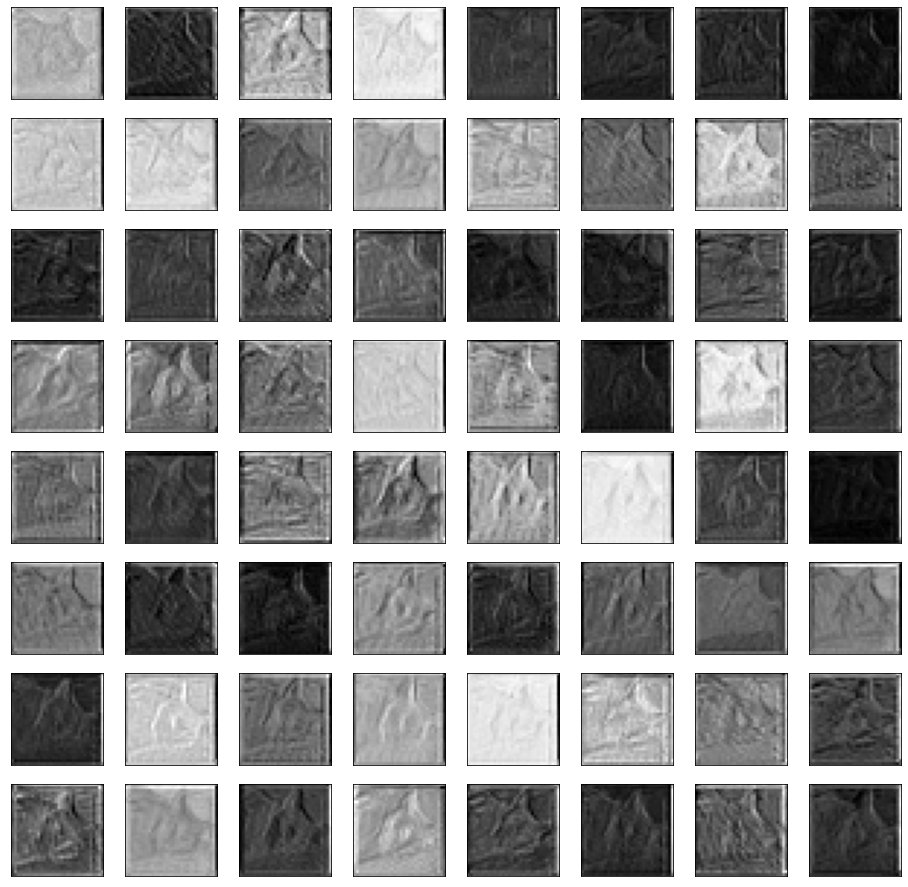

In [34]:
# Visualization
feature_maps = model.predict(sample_image)

# plot the output from each block
square = 8
ix = 1
fig = plt.figure(figsize=(16, 16))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap="binary")
		ix += 1

# # show the figure
# plt.show()

# # serialize plot
# fig.savefig("10th_conv_filter.png")

In [35]:
wandb.init(project="training-bn-only", id="fmaps-resnet-adam")
wandb.log({"10th_conv_filter": fig})
plt.close()

In [36]:
# conv layer at 1st index
model = Model(inputs=resnet_adam.inputs, outputs=resnet_adam.layers[1].output)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 32, 32, 16)        448       
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


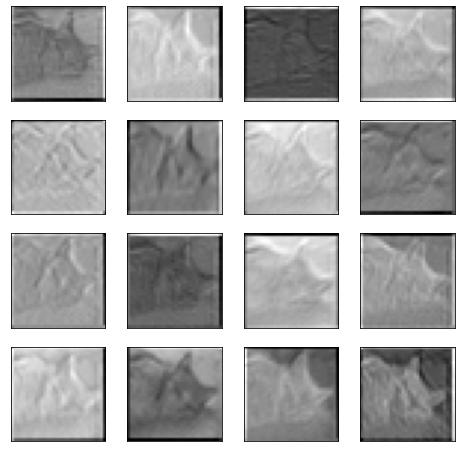

In [37]:
feature_maps = model.predict(sample_image)

# plot the output from each block
square = 4
ix = 1
fig = plt.figure(figsize=(8, 8))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap="binary")
		ix += 1

# # show the figure
# plt.show()

# # save the figure
# fig.savefig("first_conv_filter.png")

In [39]:
wandb.init(project="training-bn-only", id="fmaps-resnet-adam-2")
wandb.log({"1st_conv_filter": fig})
plt.close()

In [0]:
# Load the weights of BN only ResNet
resnet_bn_adam = get_training_model("adam")
resnet_adam_bn_weights = wandb.restore("model-best.h5", run_path="sayakpaul/training-bn-only/bn-only-adam")
resnet_bn_adam.load_weights(resnet_adam_bn_weights.name)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_204 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
re_lu_204 (ReLU)             (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 32, 32, 16)        272       
_________________________________________________________________
batch_normalization_205 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
re_lu_205 (ReLU)             (None, 32, 32, 16)        0   

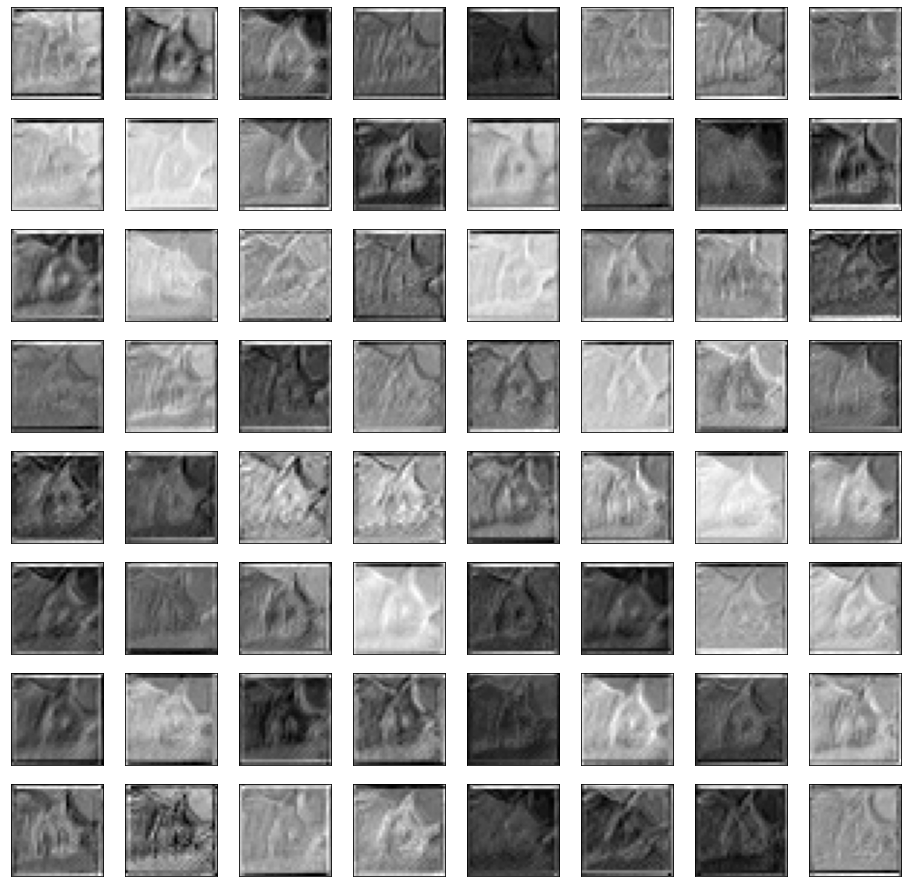

In [44]:
# conv layer at 10th index
model = Model(inputs=resnet_bn_adam.inputs, outputs=resnet_bn_adam.layers[10].output)
model.summary()

# Visualization
feature_maps = model.predict(sample_image)

# plot the output from each block
square = 8
ix = 1
fig = plt.figure(figsize=(16, 16))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap="binary")
		ix += 1

In [45]:
wandb.init(project="training-bn-only", id="fmaps-resnet-bn-adam")
wandb.log({"10th_conv_filter": fig})
plt.close()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 32, 32, 16)        448       
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


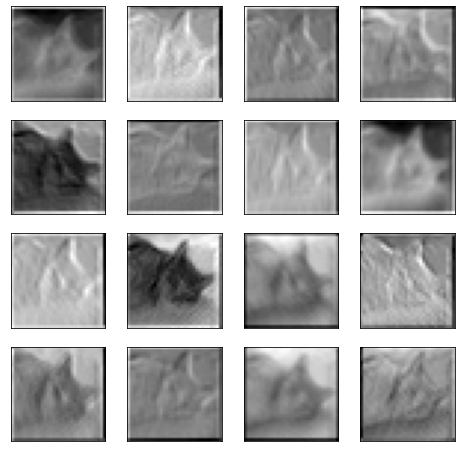

In [47]:
# conv layer at 1st index
model = Model(inputs=resnet_bn_adam.inputs, outputs=resnet_bn_adam.layers[1].output)
model.summary()

# Visualization
feature_maps = model.predict(sample_image)

# plot the output from each block
square = 4
ix = 1
fig = plt.figure(figsize=(8, 8))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap="binary")
		ix += 1

In [48]:
wandb.init(project="training-bn-only", id="fmaps-resnet-bn-adam-2")
wandb.log({"1st_conv_layer": fig})
plt.close()